In [1]:
import os
import numpy as np
import librosa
import pandas as pd
from scipy import stats
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import (
    Conv1D, BatchNormalization, MaxPooling1D,
    Bidirectional, LSTM, Dropout, Dense, Lambda, Layer, Masking
)
from tensorflow.keras.regularizers import l2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from hmmlearn import hmm
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import random
import warnings
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import shuffle

In [2]:
# Percorsi dei file
SAVE_DIR    = r"C:\Users\franc\OneDrive - unime.it\Serrano\EMOVO\Totale"
GLOBAL_FILE = os.path.join(SAVE_DIR, "emovo_global_features.xlsx")
LOCAL_FILE  = os.path.join(SAVE_DIR, "emovo_local_features.xlsx")

# Normalizzazione per speaker
def normalize_split_per_speaker(train_df, val_df, test_df, feature_cols):
    scaler = StandardScaler()
    scaler.fit(train_df[feature_cols])
    train_df[feature_cols] = scaler.transform(train_df[feature_cols])
    val_df[feature_cols]   = scaler.transform(val_df[feature_cols])
    test_df[feature_cols]  = scaler.transform(test_df[feature_cols])
    return train_df, val_df, test_df

# Suddivisione fissa: 10 Train, 1 Validation, 3 Test per emozione
def balanced_emotion_split(df, emotion_col='emotion', file_col='file', n_train=10, n_val=1, n_test=3):
    train_files, val_files, test_files = [], [], []

    for emotion in df[emotion_col].unique():
        subset = df[df[emotion_col] == emotion]
        subset = shuffle(subset, random_state=42)

        if len(subset) < (n_train + n_val + n_test):
            continue

        train = subset.iloc[:n_train]
        val = subset.iloc[n_train:n_train + n_val]
        test = subset.iloc[n_train + n_val:n_train + n_val + n_test]

        train_files.extend(train[file_col].tolist())
        val_files.extend(val[file_col].tolist())
        test_files.extend(test[file_col].tolist())

    return train_files, val_files, test_files

# Caricamento dei dati
df_global = pd.read_excel(GLOBAL_FILE)
df_local  = pd.read_excel(LOCAL_FILE)

# Speaker
speakers = ['f1', 'f2', 'f3', 'm1', 'm2', 'm3']

# Dizionari per salvare sets per speaker
g_splits = {}
l_splits = {}

for spk in speakers:
    # Filtro per speaker
    dfg = df_global[df_global['speaker'] == spk].reset_index(drop=True)
    dfl = df_local[df_local['speaker'] == spk].reset_index(drop=True)

    # Estrazione utterance uniche
    utt = dfg[['file', 'emotion']].drop_duplicates()

    if len(utt) < 10:
        print(f"[SKIP] Speaker {spk} ha poche utteranze.")
        continue

    train_files, val_files, test_files = balanced_emotion_split(utt, emotion_col='emotion', file_col='file', n_train=10, n_val=1, n_test=3)

    # Global
    g_train = dfg[dfg['file'].isin(train_files)].reset_index(drop=True)
    g_val   = dfg[dfg['file'].isin(val_files)].reset_index(drop=True)
    g_test  = dfg[dfg['file'].isin(test_files)].reset_index(drop=True)

    # Colonne da normalizzare
    non_feature_cols = ['file', 'emotion', 'speaker', 'utt_id', 'frame']
    g_feat_cols = [col for col in g_train.columns if col not in non_feature_cols]

    # Normalizzazione per speaker
    g_train, g_val, g_test = normalize_split_per_speaker(g_train, g_val, g_test, g_feat_cols)

    # Salvataggio per speaker
    g_splits[spk] = {'train': g_train, 'val': g_val, 'test': g_test}

    # Verifiche
    print(f"Speaker {spk.upper()}")
    print(f"Global -  Train: {len(g_train)},  Val: {len(g_val)},  Test: {len(g_test)}")

    print("\n Conteggio emozioni per speaker e sets:")

for spk in g_splits.keys():
    print(f"\nSpeaker: {spk.upper()}")
    for split in ['train', 'val', 'test']:
        df = g_splits[spk][split]
        counts = df['emotion'].value_counts().sort_index()
        print(f"  {split.capitalize():<6}: {counts.to_dict()}")

Speaker F1
Global -  Train: 70,  Val: 7,  Test: 21

 Conteggio emozioni per speaker e sets:
Speaker F2
Global -  Train: 70,  Val: 7,  Test: 21

 Conteggio emozioni per speaker e sets:
Speaker F3
Global -  Train: 70,  Val: 7,  Test: 21

 Conteggio emozioni per speaker e sets:
Speaker M1
Global -  Train: 70,  Val: 7,  Test: 21

 Conteggio emozioni per speaker e sets:
Speaker M2
Global -  Train: 70,  Val: 7,  Test: 21

 Conteggio emozioni per speaker e sets:
Speaker M3
Global -  Train: 70,  Val: 7,  Test: 21

 Conteggio emozioni per speaker e sets:

Speaker: F1
  Train : {'Anger': 10, 'Disgust': 10, 'Fear': 10, 'Happiness': 10, 'Neutral': 10, 'Sadness': 10, 'Surprise': 10}
  Val   : {'Anger': 1, 'Disgust': 1, 'Fear': 1, 'Happiness': 1, 'Neutral': 1, 'Sadness': 1, 'Surprise': 1}
  Test  : {'Anger': 3, 'Disgust': 3, 'Fear': 3, 'Happiness': 3, 'Neutral': 3, 'Sadness': 3, 'Surprise': 3}

Speaker: F2
  Train : {'Anger': 10, 'Disgust': 10, 'Fear': 10, 'Happiness': 10, 'Neutral': 10, 'Sadness': 

PCA: 966→57 comp (95% var.)
Gen   0 | 0.2857
Gen  10 | 0.5584
Gen  20 | 0.6623
Gen  30 | 0.7273
Gen  40 | 0.7403
Gen  50 | 0.8052
Gen  60 | 0.8571
Gen  70 | 0.8571
Gen  80 | 0.8961
Gen  90 | 0.9091
Gen 100 | 0.9221
Gen 110 | 0.9351
Gen 120 | 0.9351
Gen 130 | 0.9610
Gen 140 | 0.9610
Gen 150 | 0.9740
Gen 160 | 0.9740
Gen 170 | 0.9740
Gen 180 | 0.9870
Gen 190 | 0.9870
Gen 199 | 0.9870


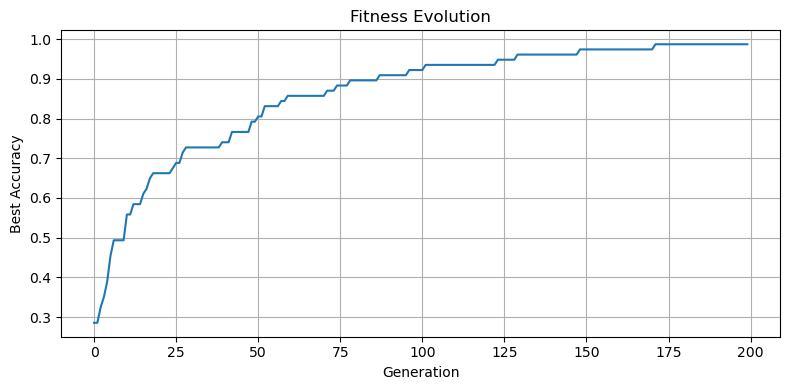


Risultati Test
Accuracy: 0.8571428571428571


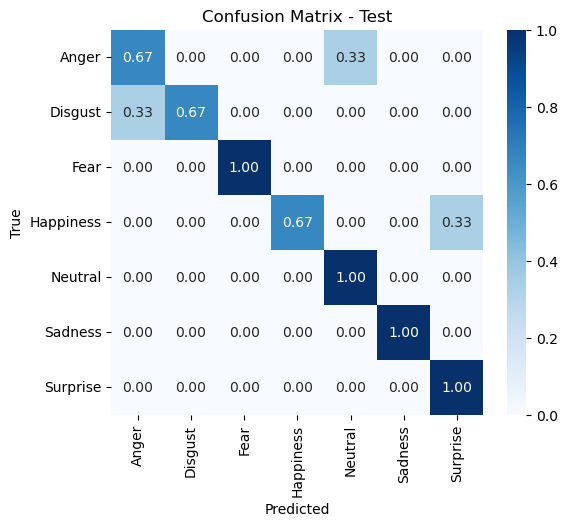

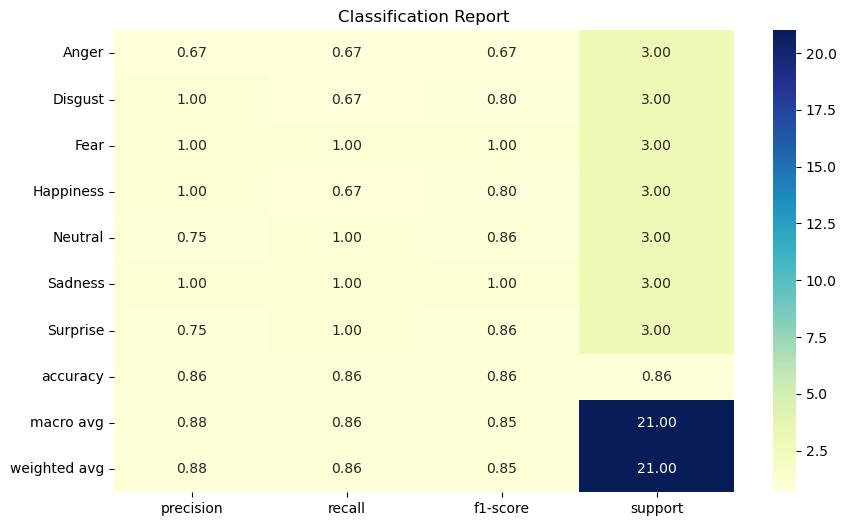

In [5]:
# BEL
class BELNode:
    #Un singolo nodo BEL (Amigdala + Corteccia orbifrontale) per una classe
    def __init__(self, n_features):
        self.nf = n_features
        #Il numero dei pesi e input è pari al numero di feature post PCA
        self.w = np.random.uniform(-0.5,0.5,n_features+1)
        self.v = np.random.uniform(-0.5,0.5,n_features+2)
    def forward(self, x):
        ath = np.max(x) #Massimo s che entra nel talamo
        #Output della Corteccia OrbiFrontale
        Ea  = np.dot(self.v[:self.nf], x) + ath*self.v[self.nf] + self.v[-1]
        #Output dell'Amigdala
        Eo  = np.dot(self.w[:self.nf], x) + self.w[-1]
        return Ea - Eo #Per ogni classe

class GABEL:
    def __init__(self, n_features, n_classes,
                 pop_size=150, n_gen=300,
                 p_crossover=0.8, p_mut=0.1):
        self.nf, self.nc = n_features, n_classes
        self.pop_size, self.n_gen = pop_size, n_gen
        self.p_crossover, self.p_mut = p_crossover, p_mut
        self.len_node  = (n_features+1)+(n_features+2)
        self.len_chrom = self.len_node * n_classes

    def _decode(self, chrom):
        nodes, idx = [], 0
        for _ in range(self.nc):
            node = BELNode(self.nf)
            node.w = chrom[idx:idx+self.nf+1]; idx += self.nf+1
            node.v = chrom[idx:idx+self.nf+2]; idx += self.nf+2
            nodes.append(node)
        return nodes

    def _fitness(self, chrom, X, y):
        nodes = self._decode(chrom)
        scores = np.stack([[n.forward(x) for n in nodes] for x in X])
        ypred  = np.argmax(scores,axis=1)
        return -accuracy_score(y, ypred)

    def _init_population(self):
        return [np.random.uniform(-0.5,0.5,self.len_chrom)
                for _ in range(self.pop_size)]

    def _crossover(self, p1, p2):
        if random.random() > self.p_crossover:
            return p1.copy(), p2.copy()
        pt = random.randint(1, self.len_chrom-2)
        return (np.concatenate([p1[:pt], p2[pt:]]),
                np.concatenate([p2[:pt], p1[pt:]]))

    def _mutate(self, chrom):
        for i in range(self.len_chrom):
            if random.random() < self.p_mut:
                chrom[i] += np.random.normal(0,0.2)
        return chrom

    def fit(self, X, y, verbose=True):
        pop = self._init_population()
        best, best_fit = None, 1e9
        self.fitness_curve_ = []
        for g in range(self.n_gen):
            fits = np.array([self._fitness(ind, X, y) for ind in pop])
            idx_best = int(np.argmin(fits))
            if fits[idx_best] < best_fit:
                best_fit, best = fits[idx_best], pop[idx_best].copy()
            if verbose and (g % 10 == 0 or g == self.n_gen-1):
                print(f"Gen {g:3d} | {-best_fit:.4f}")
            self.fitness_curve_.append(-best_fit)  # Accuracy positiva
            # Selezione Roulette
            accs = -fits
            accs = accs - accs.min() + 1e-12
            probs = accs / accs.sum()

            new_pop = []
            while len(new_pop) < self.pop_size:
                i1, i2 = np.random.choice(len(pop), size=2,
                                          replace=False, p=probs)
                p1, p2 = pop[i1], pop[i2]
                c1, c2 = self._crossover(p1, p2)
                new_pop.append(self._mutate(c1))
                if len(new_pop) < self.pop_size:
                    new_pop.append(self._mutate(c2))
            pop = new_pop
        self.nodes_ = self._decode(best)
        return self


    def predict(self, X):
        scores = np.stack([[n.forward(x) for n in self.nodes_] for x in X])
        return np.argmax(scores, axis=1)


# Colonne da escludere
non_feat = {'file','emotion','speaker','utt_id','frame'}

# Definizione delle features
global_feats = [c for c in g_splits['f3']['train'].columns if c not in non_feat]



# Unione Train + Validation
df_trval = pd.concat([g_splits['f3']['train'], g_splits['f3']['val']], ignore_index=True)
X_trval  = df_trval[global_feats].values
y_trval  = df_trval["emotion"].values
X_test_ = g_splits['f3']['test']
X_test   = X_test_[global_feats].values
y_test   = X_test_["emotion"].values

# Codifica etichette
le = LabelEncoder().fit(y_trval)
y_trval_enc = le.transform(y_trval)
y_test_enc  = le.transform(y_test)

# PCA fisso
pca       = PCA(n_components=0.95, svd_solver="full", random_state=0)
X_tr_pca  = pca.fit_transform(X_trval)
X_te_pca  = pca.transform(X_test)
print(f"PCA: {X_trval.shape[1]}→{X_tr_pca.shape[1]} comp ({0.95*100:.0f}% var.)")

# Addestramento GA-BEL su Train+Validation
model = GABEL(n_features=X_tr_pca.shape[1],
                n_classes=len(le.classes_),
                pop_size=100, n_gen=200,
                p_crossover=0.8, p_mut=0.1)
model.fit(X_tr_pca, y_trval_enc)

plt.figure(figsize=(8, 4))
plt.plot(model.fitness_curve_)
plt.xlabel("Generation")
plt.ylabel("Best Accuracy")
plt.title("Fitness Evolution")
plt.grid(True)
plt.tight_layout()
plt.show()


# Predizione e Valutazione su test
y_pred_enc = model.predict(X_te_pca)
y_pred     = le.inverse_transform(y_pred_enc)

# Calcolo Accuracy
print("\nRisultati Test")
print("Accuracy:", accuracy_score(y_test, y_pred))

# Matrice di confusione normalizzata
cm = confusion_matrix(y_test, y_pred, normalize='true')
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt=".2f",
            xticklabels=le.classes_,
            yticklabels=le.classes_,
            cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Test')
plt.show()

# CLASSIFICATION REPORT
report_dict = classification_report(
    y_test,
    y_pred,
    target_names=le.classes_,
    output_dict=True
)
report_df = pd.DataFrame(report_dict).transpose()

# Heatmap
report_df_filtered = report_df
heatmap_data = report_df_filtered

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap='YlGnBu')
plt.title("Classification Report")
plt.show()


Accuracy: 0.7142857142857143


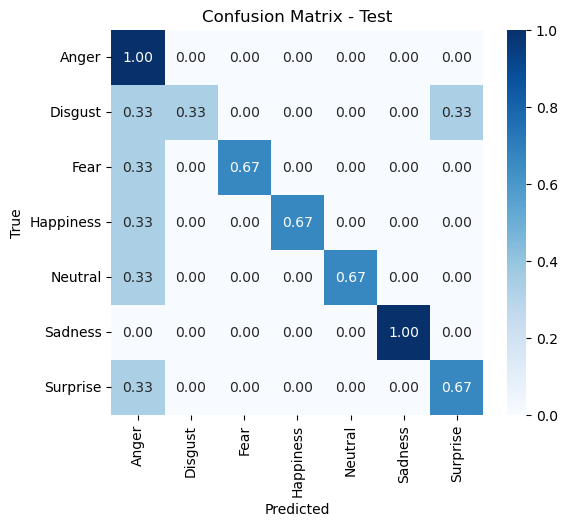

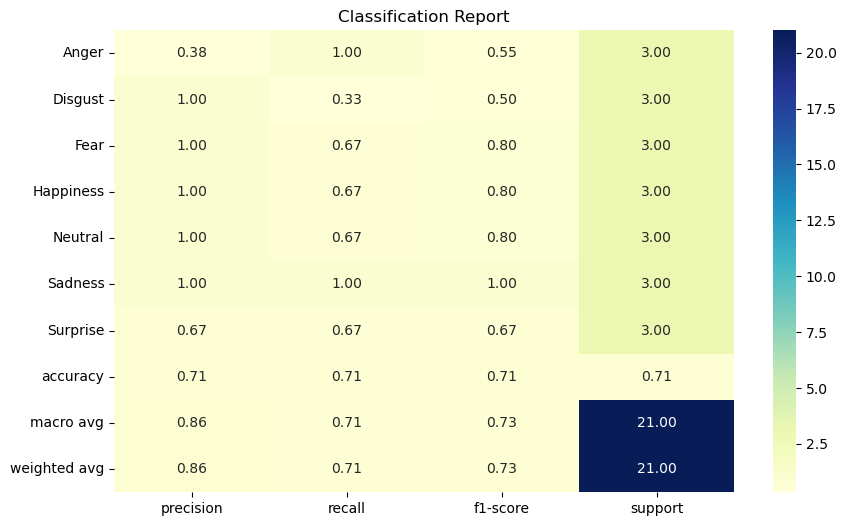

In [7]:
# Definizione e addestramento del modello
svm = SVC(kernel='rbf', C=1, gamma=0.1, random_state=0)
svm.fit(X_tr_pca, y_trval_enc)

# Predizione su test set
y_svm_pred_enc = svm.predict(X_te_pca)

# Etichette originali
y_svm_pred = le.inverse_transform(y_svm_pred_enc)

# Calcolo Accuracy
acc_svm = accuracy_score(y_test, y_svm_pred)
print("Accuracy:", acc_svm)

# Matrice di confusione normalizzata
cm = confusion_matrix(y_test, y_svm_pred, normalize='true')
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt=".2f",
            xticklabels=le.classes_,
            yticklabels=le.classes_,
            cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Test')
plt.show()

# CLASSIFICATION REPORT
report_dict = classification_report(
    y_test,
    y_svm_pred,
    target_names=le.classes_,
    output_dict=True
)
report_df = pd.DataFrame(report_dict).transpose()

# Heatmap
report_df_filtered = report_df
heatmap_data = report_df_filtered

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap='YlGnBu')
plt.title("Classification Report")
plt.show() 